# Scikit-Learn Demonstration

Demonstration of scikit learn for machine learning.

In this workflow we demonstrate the plug and play nature of scikit learn machine learning models.  

For an unconventional dataset we demonstrate the following steps:
    
    1. instantiation
    2. fitting
    3. prediction
    4. cross validation
    
We will work with the following regression methods:

* linear regression
* multilinear regression
* decision tree regression
* support vector machine regression

We will demonstrate together a model and then you will pick any 2 predictor features and build your own model.

* try some new hyperparameters and observe the model performance

We will also need some standard packages.

In [1]:
import os                                                 # to set current working directory 
import math                                               # basic calculations like square root
from sklearn.model_selection import train_test_split      # train and test split
from sklearn import svm                                   # support vector machine methods
from sklearn import tree                                  # tree program from scikit learn (package for machine learning)
from sklearn.metrics import mean_squared_error, r2_score  # specific measures to check our models
import pandas as pd                                       # DataFrames and plotting
import pandas.plotting as pd_plot
import numpy as np                                        # arrays and matrix math
import matplotlib.pyplot as plt                           # plotting
from intake import cat                                    # data catalogue

/opt/tljh/user/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['sql_cat', 'sql', 'sql_auto', 'sql_manual'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


#### Declare functions

Let's define a couple of functions to streamline plotting correlation matrices and visualization of a machine learning regression model responce over the 2 predictor features. 

In [2]:
def plot_corr(dataframe,size=10):                         # plots a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    
def visualize_model(model,xfeature,yfeature,response,title,):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.RdYlBu
    plot_step = 0.02
    x_min, x_max = min(xfeature) - 1, max(xfeature) + 1
    y_min, y_max = min(yfeature) - 1, max(yfeature) + 1
    resp_min = round(min(response)); resp_max = round(max(response));
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    z_min = round(min(response)); z_max = round(max(response))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max)

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    return(plt)


#### Read the data table

In [3]:
my_data = cat.unconv_MV().read()

Let's visualize the first several rows of our data stored in a DataFrame so we can make sure we successfully loaded the data file.

In [4]:
my_data.head()                                            # preview the first 5 rows of the dataframe

,WellIndex,Por,LogPerm,AI,Brittle,TOC,VR,Production
0,1,15.91,1.67,3.06,14.05,1.36,1.85,177.381958
1,2,15.34,1.65,2.60,31.88,1.37,1.79,1479.767778
2,3,20.45,2.02,3.13,63.67,1.79,2.53,4421.221583
3,4,11.95,1.14,3.90,58.81,0.40,2.03,1488.317629
4,5,19.53,1.83,2.57,43.75,1.40,2.11,5261.094919


Let's remove the well index and check the summary summary statistics.

In [5]:
my_data = my_data.iloc[:,1:8]                             # copy all rows and columns 1 through 8, note 0 column is removed
my_data.describe().transpose()                            # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.719480,15.077006,-10.500000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.003810,0.504978,-0.260000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


It is good that we checked the summary statistics, because we have some negative values for brittleness and total organic carbon. The is physically imposible.  The values must be in error. We know the lowest possible values are 0.0, so we will truncate on 0.0.  We use the *get_numerical_data()* DataFrame member function to get a shallow copy of the data from the DataFrame.  Since it is a shallow copy, any changes we make to the copy are made to the data in the original DataFrame.  This allows us to apply this simple conditional statement to all the data values in the DataFrame all at once.

In [6]:
num = my_data._get_numeric_data()                         # get the numerical values
num[num < 0] = 0                                          # truncate negative values to 0.0
my_data.describe().transpose()                            # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.731480,15.033593,0.000000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.006170,0.499838,0.000000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


Let's assign min and max values for visualization

In [7]:
fmin = [5.0,0.1,0.95,0.0,0.0,0.9,0.0]
fmax = [25.0,2.6,4.7,95.0,2.8,3.0,13000.0]

This dataset has variables from 1,000 unconventional wells including well average porosity, log transform of permeability (to linearize the relationships with other variables), accoustic impedance (kg/m2s*10^6), brittness ratio (%), total organic carbon (%), vitrinite reflectance (%), and initial production 90 day average (MCFPD).  Note, the dataset is synthetic.

#### Calculate the correlation matrix 

For multivariate analysis it is a good idea to check the correlation matrix.  We can calculate it and view it in the console with these commands.

In [8]:
corr_matrix = np.corrcoef(my_data, rowvar = False)
print(np.around(corr_matrix,2))                           # print the correlation matrix to 2 decimals

[[ 1.    0.81 -0.51 -0.25  0.71  0.08  0.69]
 [ 0.81  1.   -0.32 -0.15  0.51  0.05  0.57]
 [-0.51 -0.32  1.    0.17 -0.55  0.49 -0.33]
 [-0.25 -0.15  0.17  1.   -0.24  0.3  -0.07]
 [ 0.71  0.51 -0.55 -0.24  1.    0.31  0.5 ]
 [ 0.08  0.05  0.49  0.3   0.31  1.    0.14]
 [ 0.69  0.57 -0.33 -0.07  0.5   0.14  1.  ]]


Note the 1.0 diagonal resulting from the correlation of each variable with themselves.  

Let's use our function declared above to make a graphical correlation matrix visualization.  This may inprove our ability to spot features.  It relies on the built in correlation matrix method with Numpy DataFrames and MatPlotLib for plotting.

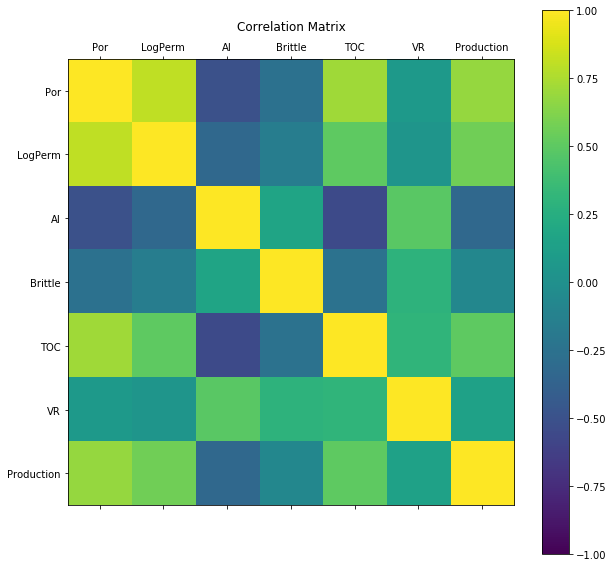

In [9]:
plot_corr(my_data,10)                                      # using our correlation matrix visualization function
plt.show()

This looks good.  There is a mix of correlation magnitudes. Of course, correlation coeffficients are limited to degree of linear correlations.  For more complete information, let's look at the matrix scatter plot from the Pandas package. 

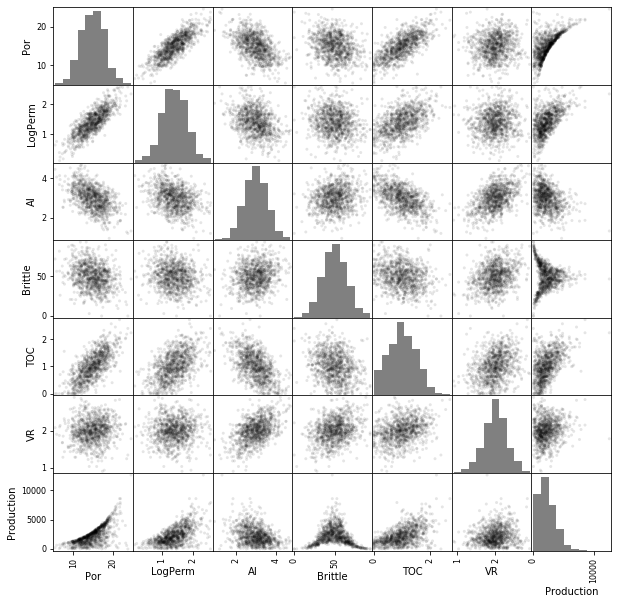

In [10]:
pd_plot.scatter_matrix(my_data, alpha = 0.1,              # pandas matrix scatter plot
    figsize=(10, 10),color = 'black', hist_kwds={'color':['grey']})
plt.show()

#### Working with Only Two Predictor Features to Predict One Response Feature

Let's simplify the problem to 2 features, to predict one response feature, Production rate.  We will also reduce the number of wells from 1,000 to 500.  By working with only 2 predictor features, it is very easy to visualize the segmentation of the feature space (it is only 2D and the model can be interogated exhaustively on a single plot).

We will demonstrate with:

* Porosity and Brittleness

to predict:

* Production

Then you will have a chance to run the workflow again with your own selection for predictor features.

To update the predictor features change the code in the box below:

```python
predictor_features = ['Por','Brittle'] 
```

You can any of these:

1. Por
2. LogPerm
3. AI
4. Brittle
5. TOC
6. VR

Note the feature names are caps sensitive.

In [11]:
# Select 2 predictor features here:
predictor_features = ['Por','Brittle']           # for the first demonstration run we will use porosity and brittleness
#

response_feature = 'Production'

pindex = np.argwhere(my_data.columns.isin(predictor_features)).ravel()
print('Selected predictor features: \n0: ' + predictor_features[0] + ', index = ' + str(pindex[0]) + '.')
print('1: ' + predictor_features[1] + ', index = ' + str(pindex[1]) + '.')
rindex = np.argwhere(my_data.columns.isin([response_feature])).ravel()
print('\nSelected response feature: \n' + response_feature + ', index = ' + str(rindex[0]) + '.')

#my_data_cut = my_data.iloc[0:500,:] 
X = my_data[predictor_features]                # extract the 2 selected response features, 500 samples to a X array
y = my_data[[response_feature]]                # extract selected response 500 samples to a response array

Selected predictor features: 
0: Por, index = 0.
1: Brittle, index = 3.

Selected response feature: 
Production, index = 6.


Let's check the summary statistics of Predictor Features 1 and 2 and the Response Feature.

In [12]:
X.describe().transpose()                   # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.95046,3.029634,5.4,12.8575,14.985,17.08,24.65
Brittle,1000.0,49.73148,15.033593,0.0,39.7225,49.680,59.17,93.47


In [13]:
y.describe().transpose()                   # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


Now let's withhold 100 samples as testing data and retain the remaining 400 as training data. 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73073)
n_train = len(X_train)
n_test = len(X_test)
print('Number of training ' + str(n_train) + ', number of test ' + str(n_test))

Number of training 800, number of test 200


Let's compare the univariate statistics of Predictor Features 1 and 2 and the Response Feature for the training and testing datasets.  
 
 * let's check for bias and extrapolation.

In [15]:
X_train.describe().transpose()                   # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,800.0,15.011125,3.042271,5.4,12.8450,15.050,17.1625,24.65
Brittle,800.0,50.177425,14.908855,0.0,40.4175,50.385,59.3850,93.47


In [16]:
X_test.describe().transpose()                   # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,200.0,14.7078,2.973676,5.79,12.9075,14.780,16.710,21.89
Brittle,200.0,47.9477,15.431896,3.03,37.7325,46.845,58.015,89.85


In [17]:
y_train.describe().transpose()                   # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Production,800.0,2287.66963,1492.387264,2.713535,1215.322405,2009.467003,3067.880883,12568.64413


In [18]:
y_test.describe().transpose()                   # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Production,200.0,2085.800523,1337.202026,15.473562,1092.864915,1902.283707,2886.903518,7141.265029


Now let's plot the training and testing dataset distributions to check coverage and extrapolation.

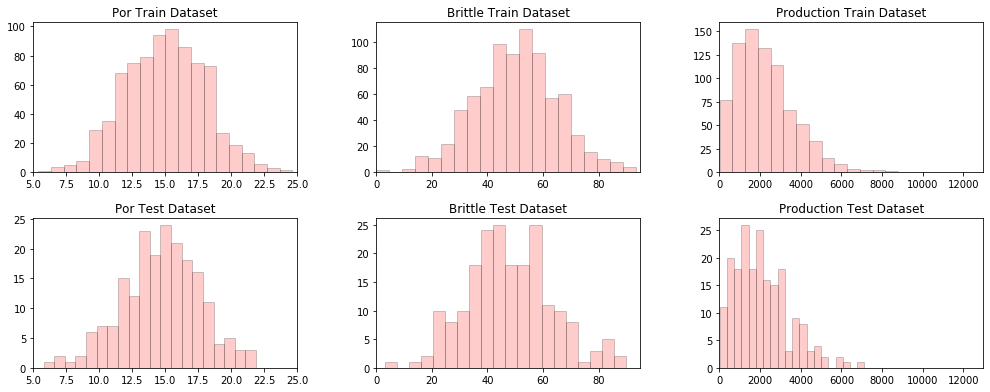

In [19]:
plt.subplot(231)
plt.hist(X_train[predictor_features[0]], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title(predictor_features[0] + ' Train Dataset'); plt.xlim(fmin[pindex[0]],fmax[pindex[0]])

plt.subplot(232)
plt.hist(X_train[predictor_features[1]], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title(predictor_features[1] + ' Train Dataset'); plt.xlim(fmin[pindex[1]],fmax[pindex[1]])

plt.subplot(233)
plt.hist(y_train[response_feature], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title(response_feature + ' Train Dataset'); plt.xlim(fmin[rindex[0]],fmax[rindex[0]])

plt.subplot(234)
plt.hist(X_test[predictor_features[0]], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title(predictor_features[0] + ' Test Dataset'); plt.xlim(fmin[pindex[0]],fmax[pindex[0]])

plt.subplot(235)
plt.hist(X_test[predictor_features[1]], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title(predictor_features[1] + ' Test Dataset'); plt.xlim(fmin[pindex[1]],fmax[pindex[1]])

plt.subplot(236)
plt.hist(y_test[response_feature], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title(response_feature + ' Test Dataset'); plt.xlim(fmin[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.3)
plt.show()

The distributions are well behaved, we cannot observe obvious gaps nor truncations.  

Let's look at a scatter plot of Predictor Feature 1 vs 2 with points colored by Response Feature.  

* Let's plot the training and testing datasets to check coverage and extrapolation in the features space.

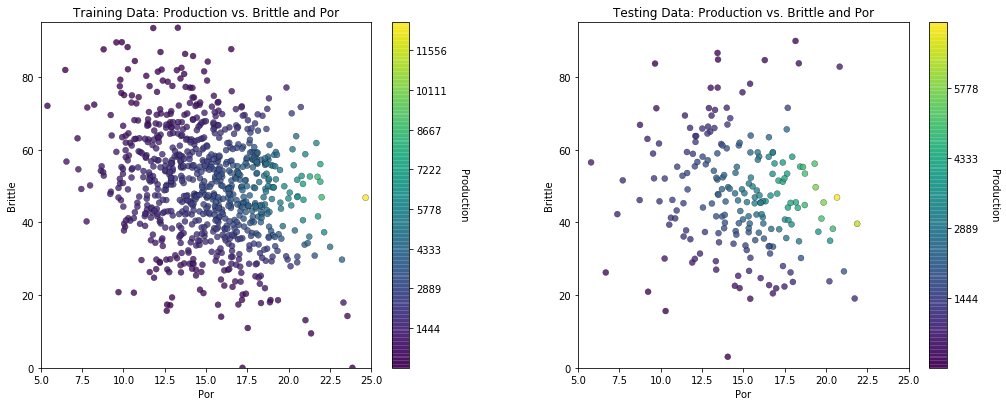

In [20]:
plt.subplot(121)
im = plt.scatter(X_train[predictor_features[0]],X_train[predictor_features[1]],s=None, c=y_train[response_feature], marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Training Data: ' + response_feature + ' vs. ' + predictor_features[1] + ' and ' + predictor_features[0]); plt.xlabel(predictor_features[0]); plt.ylabel(predictor_features[1])
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(fmin[rindex[0]],fmax[rindex[0]], 10));
plt.xlim(fmin[pindex[0]],fmax[pindex[0]]); plt.ylim(fmin[pindex[1]],fmax[pindex[1]])
cbar.set_label(response_feature, rotation=270, labelpad=20)

plt.subplot(122)
im = plt.scatter(X_test[predictor_features[0]],X_test[predictor_features[1]],s=None, c=y_test[response_feature], marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Testing Data: ' + response_feature + ' vs. ' + predictor_features[1] + ' and ' + predictor_features[0]); plt.xlabel(predictor_features[0]); plt.ylabel(predictor_features[1])
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(fmin[rindex[0]],fmax[rindex[0]], 10)); 
plt.xlim(fmin[pindex[0]],fmax[pindex[0]]); plt.ylim(fmin[pindex[1]],fmax[pindex[1]])
cbar.set_label(response_feature, rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

#### Building a Linear Regression Model

Let's build our first machine learning model with scikit learn.  We will start with linear regression.  For this model we will pick one predictor feature and one response feature.  

Coefficients:  343.285, Intercept:  -2865.424


(0.0, 13000.0)

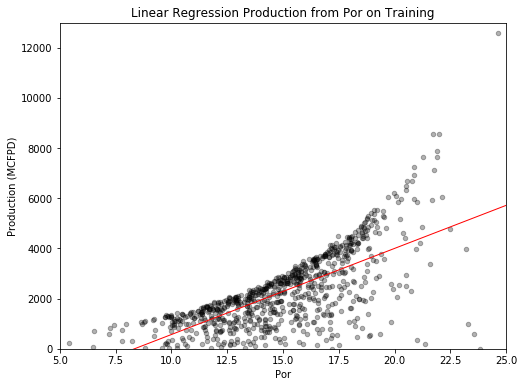

In [21]:
# Linear Regression Model with scikit learn
from sklearn import linear_model

# Step 1. Instantiate the Model 
univariate_linear_reg = linear_model.LinearRegression()

# Step 2: Fit the Data on Training Data
univariate_linear_reg.fit(X_train[predictor_features[0]].values.reshape(n_train,1), y_train[response_feature]) # fit model
univariate_linear_model = np.linspace(fmin[pindex[0]],fmax[pindex[0]],10)

# Print the model parameters
response_model = univariate_linear_reg.predict(univariate_linear_model.reshape(10,1)) # predict with the fit model
print('Coefficients: ', str(round(univariate_linear_reg.coef_[0],3)) + ', Intercept: ', str(round(univariate_linear_reg.intercept_,3))) 

# Plot model fit
plt.figure(figsize=(8,6))
plt.scatter(X_train[predictor_features[0]].values, y_train[response_feature],  color='black', s = 20, alpha = 0.3)
plt.plot(univariate_linear_model,response_model, color='red', linewidth=1)
plt.title('Linear Regression Production from ' + predictor_features[0] + ' on Training'); plt.xlabel(predictor_features[0]); plt.ylabel('Production (MCFPD)')
plt.xlim(fmin[pindex[0]],fmax[pindex[0]]); plt.ylim(fmin[rindex[0]],fmax[rindex[0]])


We can now check our model performance against the withheld testing data.

Variance explained: 0.37


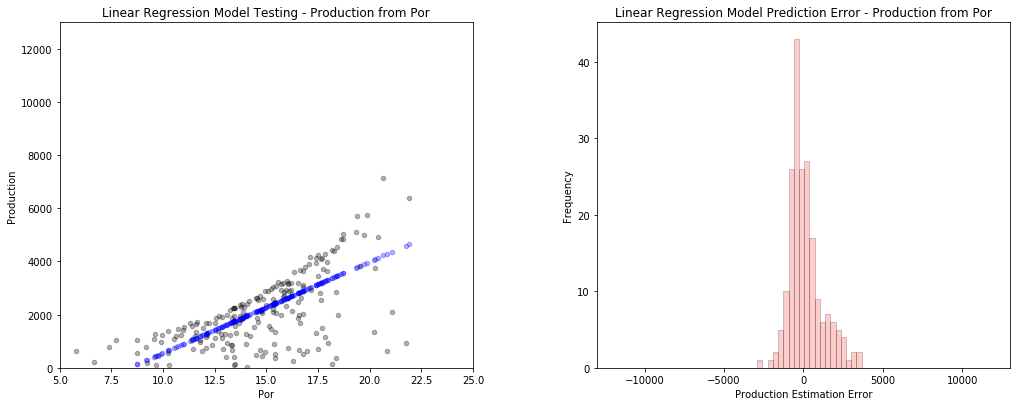

In [22]:
# Step 3: - Make predictions using the testing dataset
y_pred = univariate_linear_reg.predict(X_test[predictor_features[0]].values.reshape(n_test,1))

# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(y_test, y_pred))

# Plot testing diagnostics 
plt.subplot(121)
plt.scatter(X_test[predictor_features[0]].values, y_test[response_feature].values,  color='black', s = 20, alpha = 0.3)
plt.scatter(X_test[predictor_features[0]], y_pred, color='blue', s = 20, alpha = 0.3)
plt.title('Linear Regression Model Testing - ' + response_feature + ' from ' + predictor_features[0]); 
plt.xlabel(predictor_features[0]); plt.ylabel(response_feature)
plt.xlim(fmin[pindex[0]],fmax[pindex[0]]); plt.ylim(fmin[rindex[0]],fmax[rindex[0]])

y_res = y_pred - y_test[response_feature].values

plt.subplot(122)
plt.hist(y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Linear Regression Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0]); 
plt.xlabel(response_feature + ' Estimation Error'); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

Now let's see how our linear regression model performs with just the second predictor feature.

Coefficients:  343.285, Intercept:  -2865.424


(0.0, 13000.0)

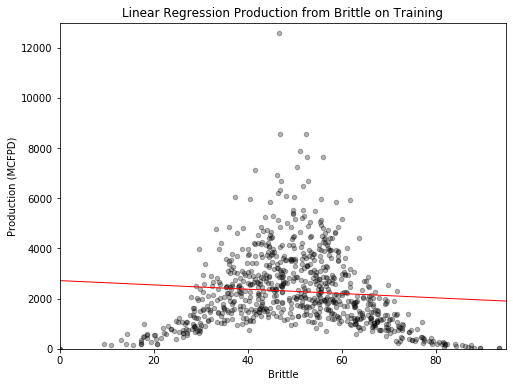

In [23]:
# Step 1. Instantiate the Model 
univariate_linear_reg2 = linear_model.LinearRegression()

# Step 2: Fit the Data on Training Data
univariate_linear_reg2.fit(X_train[predictor_features[1]].values.reshape(n_train,1), y_train[response_feature]) # fit model
univariate_linear_model2 = np.linspace(fmin[pindex[1]],fmax[pindex[1]],10)

# Print the model parameters
response_model2 = univariate_linear_reg2.predict(univariate_linear_model2.reshape(10,1)) # predict with the fit model
print('Coefficients: ', str(round(univariate_linear_reg.coef_[0],3)) + ', Intercept: ', str(round(univariate_linear_reg.intercept_,3))) 

# Plot model fit
plt.figure(figsize=(8,6))
plt.scatter(X_train[predictor_features[1]].values, y_train[response_feature],  color='black', s = 20, alpha = 0.3)
plt.plot(univariate_linear_model2,response_model2, color='red', linewidth=1)
plt.title('Linear Regression Production from ' + predictor_features[1] + ' on Training'); plt.xlabel(predictor_features[1]); plt.ylabel('Production (MCFPD)')
plt.xlim(fmin[pindex[1]],fmax[pindex[1]]); plt.ylim(fmin[rindex[0]],fmax[rindex[0]])

Variance explained: -0.03


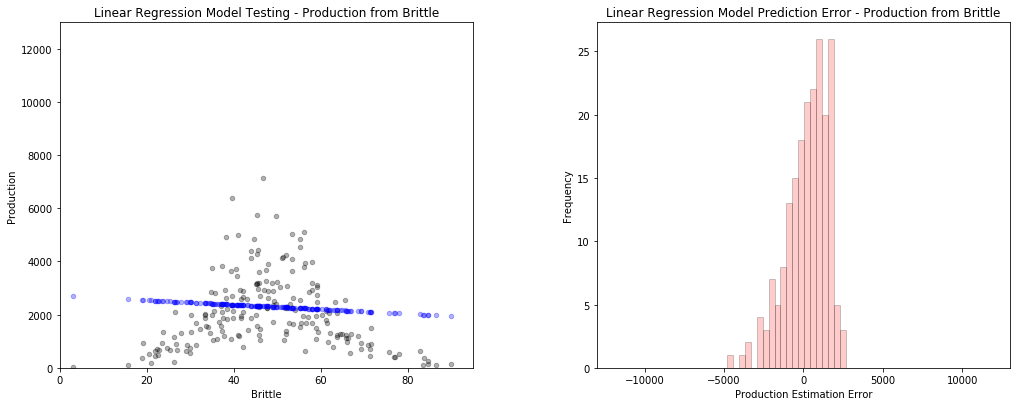

In [24]:
# Step 3: - Make predictions using the testing dataset
y_pred2 = univariate_linear_reg2.predict(X_test[predictor_features[1]].values.reshape(n_test,1))

# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(y_test, y_pred2))

# Plot testing diagnostics 
plt.subplot(121)
plt.scatter(X_test[predictor_features[1]].values, y_test[response_feature].values,  color='black', s = 20, alpha = 0.3)
plt.scatter(X_test[predictor_features[1]], y_pred2, color='blue', s = 20, alpha = 0.3)
plt.title('Linear Regression Model Testing - ' + response_feature + ' from ' + predictor_features[1]); 
plt.xlabel(predictor_features[1]); plt.ylabel(response_feature)
plt.xlim(fmin[pindex[1]],fmax[pindex[1]]); plt.ylim(fmin[rindex[0]],fmax[rindex[0]])

y_res2 = y_pred2 - y_test[response_feature].values

plt.subplot(122)
plt.hist(y_res2, alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Linear Regression Model Prediction Error - ' + response_feature + ' from ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error'); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

#### Building a Multilinear Regression Model

Let's build our second machine learning model with scikit learn.  We will work with multilinear regression!  We will use both predictor features, porosity and brittleness, and one response feature, production.  

There are no hyperparameters to tune with regular linear regression.

* note: ridge regression and LASSO offer alternatives to linear regression with regularization coefficient, a hyperparameter.

Por Coef: 360.252, Brittle Coef:  12.229, Intercept:  -3733.71
Variance explained: 0.36


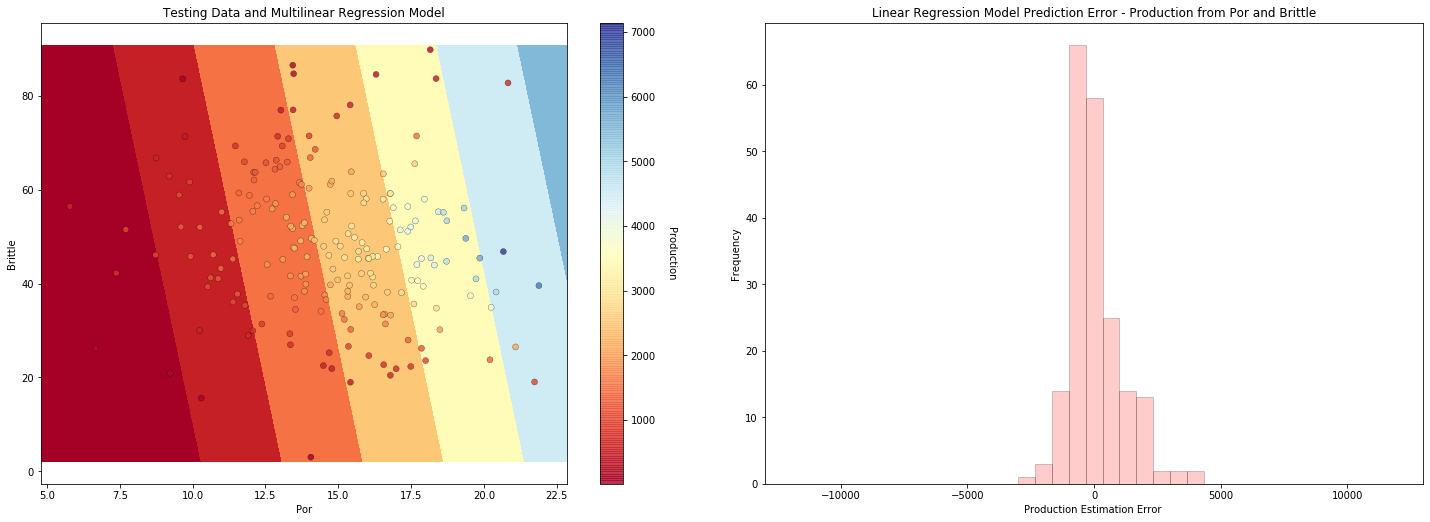

In [25]:
# Linear Regression Model with scikit learn
from sklearn import linear_model

# Step 1. Instantiate the Model 
multilinear_reg = linear_model.LinearRegression()

# Step 2: Fit the Data on Training Data
multilinear_reg.fit(X_train.values.reshape(n_train,2), y_train[response_feature]) # fit model

# Print the model parameters
print(predictor_features[0] + ' Coef: ' + str(round(multilinear_reg.coef_[0],3)) + ', ' + predictor_features[1] + ' Coef: ', str(round(multilinear_reg.coef_[1],3)) + ', Intercept: ', str(round(multilinear_reg.intercept_,3))) 

# Plot model fit
plt.subplot(121)
plt = visualize_model(multilinear_reg,X_test[predictor_features[0]],X_test[predictor_features[1]],y_test[response_feature],'Testing Data and Multilinear Regression Model')

# Step 3: - Make predictions using the testing dataset
multilinear_y_pred = multilinear_reg.predict(X_test.values.reshape(n_test,2))

# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(y_test, multilinear_y_pred))

# Calculate the error at withheld testing samples
multilinear_y_res = multilinear_y_pred - y_test[response_feature].values

plt.subplot(122)
plt.hist(multilinear_y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(-1*fmax[rindex[0]],fmax[rindex[0]],40))
plt.title('Linear Regression Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0] + ' and ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error '); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.6, wspace=0.1, hspace=0.2)
plt.show()


Including brittleness only resulted in a slight improvement.  

* due to the nonlinear nature of brittleness

#### Building a Decision Tree Regression Model

Let's build our third machine learning model with scikit learn.  We will work with a decision tree.  We will use both predictor features, porosity and brittleness, and one response feature, production.

The hyperparameters include:

* **min_samples_leaf** - the minimum number of data in each region, reduce to increase complexity
* **max_depth** - maximum number of layers of decisions, increase to increase complexity
* **max_leaf_nodes** - maximum number of regions, increase to increase complexity

/opt/tljh/user/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


Variance explained: 0.51


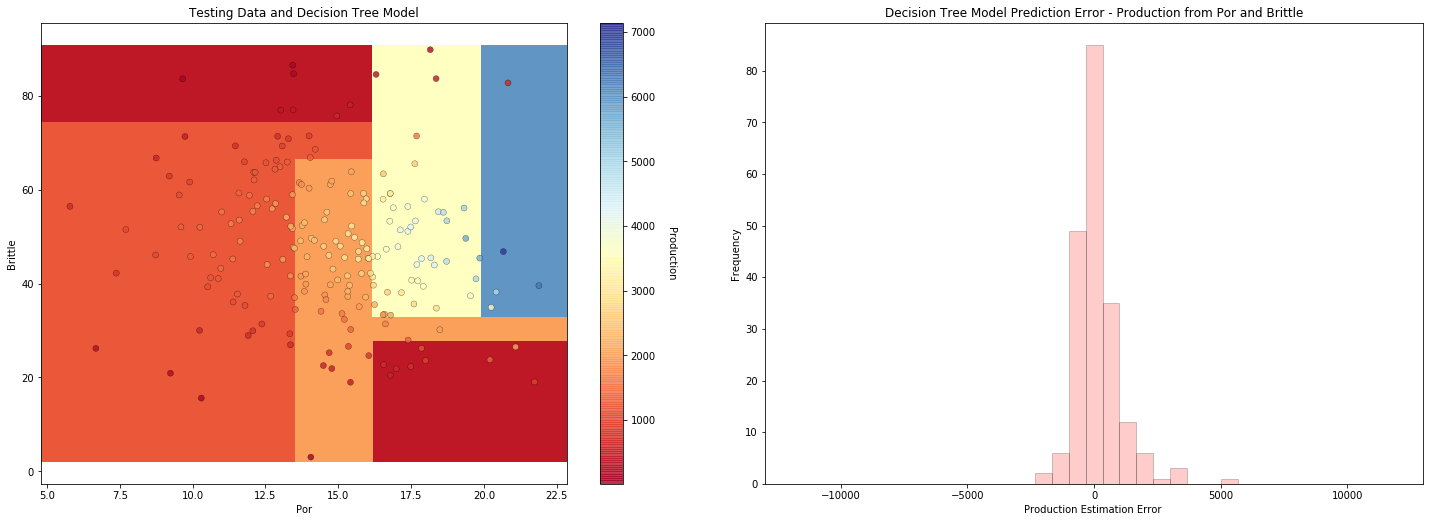

In [26]:
# Decison Tree Model with scikit learn
from sklearn.tree import tree                                     # for accessing tree information

# Step 1. Instantiate the Model 
decision_tree_reg = tree.DecisionTreeRegressor(min_samples_leaf=5, max_depth = 3)

# Step 2: Fit the Data on Training Data
decision_tree_reg.fit(X_train.values.reshape(n_train,2), y_train[response_feature]) # fit model

# Plot model fit
plt.subplot(121)
plt = visualize_model(decision_tree_reg,X_test[predictor_features[0]],X_test[predictor_features[1]],y_test[response_feature],'Testing Data and Decision Tree Model')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.3, hspace=0.2)

# Step 3: - Make predictions using the testing dataset
tree_y_pred = decision_tree_reg.predict(X_test.values.reshape(n_test,2))

# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(y_test, tree_y_pred))

# Calculate the error at withheld testing samples
tree_y_res = tree_y_pred - y_test['Production'].values

plt.subplot(122)
plt.hist(tree_y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(-1*fmax[rindex[0]],fmax[rindex[0]],40))
plt.title('Decision Tree Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0] + ' and ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error '); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.6, wspace=0.1, hspace=0.2)
plt.show()

#### Building a Support Vector Machine Regression Model

Let's build our fourth machine learning model with scikit learn.  We will work with a support vector machine!  We will use both predictor features, porosity and brittleness, and one response feature, production.  

The hyperparameters include:

* **kernel** - try linear, poly and rbf (radial basis function), for poly increase degree to increase complexity
* **C** - cost (inverse of margin width) - increase to increase complexity

/opt/tljh/user/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Variance explained: 0.18


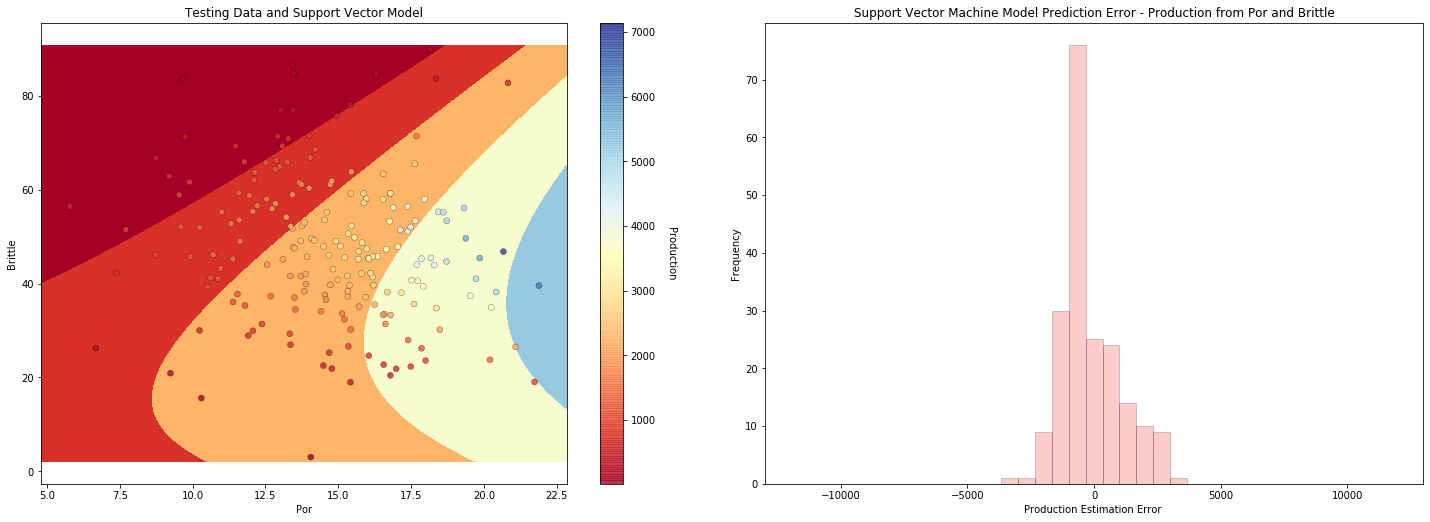

In [27]:
# Support Vector Regression Model with scikit learn
from sklearn import linear_model

# Step 1. Instantiate the Model 
support_vector_reg = svm.SVR(kernel='poly', C=0.010, gamma='auto', degree=2, epsilon=.01,coef0=1,max_iter=1000)

# Step 2: Fit the Data on Training Data
support_vector_reg.fit(X_train.values.reshape(n_train,2), y_train[response_feature]) # fit model

# Plot model fit
plt.subplot(121)
plt = visualize_model(support_vector_reg,X_test[predictor_features[0]],X_test[predictor_features[1]],y_test[response_feature],'Testing Data and Support Vector Model')

# Step 3: - Make predictions using the testing dataset
svm_y_pred = support_vector_reg.predict(X_test.values.reshape(n_test,2))

# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(y_test, svm_y_pred))

# Calculate the error at withheld testing samples
svm_y_res = svm_y_pred - y_test['Production'].values

plt.subplot(122)
plt.hist(svm_y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(-1*fmax[rindex[0]],fmax[rindex[0]],40))
plt.title('Support Vector Machine Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0] + ' and ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error '); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.6, wspace=0.1, hspace=0.2)
plt.show()

Let's put all our models together for one visualization of our:

* models with the withheld testing data

* error at withheld testing data samples distribution

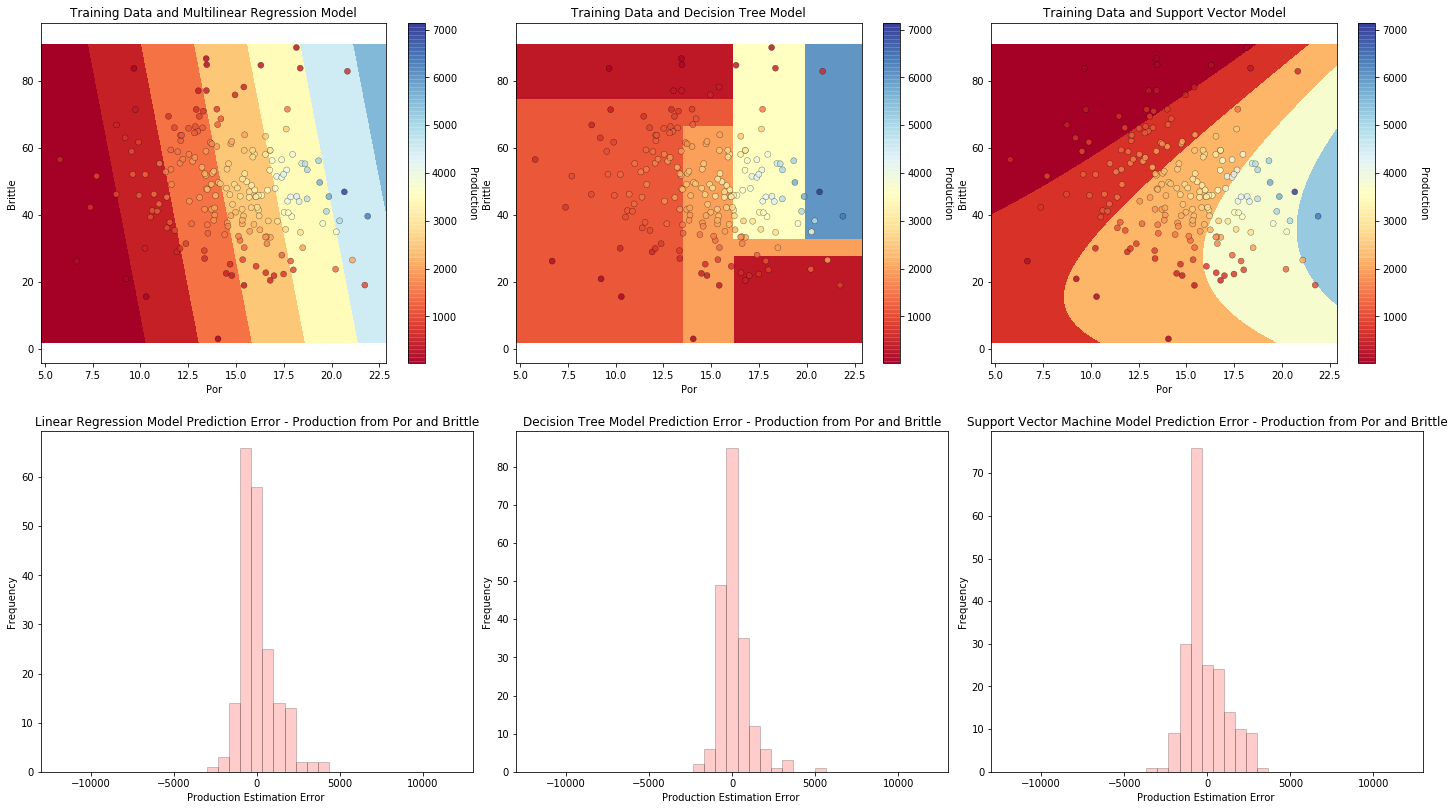

In [28]:
plt.subplot(231)
plt = visualize_model(multilinear_reg,X_test[predictor_features[0]],X_test[predictor_features[1]],y_test[response_feature],'Training Data and Multilinear Regression Model')

plt.subplot(234)
plt.hist(multilinear_y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(-1*fmax[rindex[0]],fmax[rindex[0]],40))
plt.title('Linear Regression Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0] + ' and ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error '); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplot(232)
plt = visualize_model(decision_tree_reg,X_test[predictor_features[0]],X_test[predictor_features[1]],y_test[response_feature],'Training Data and Decision Tree Model')

plt.subplot(235)
plt.hist(tree_y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(-1*fmax[rindex[0]],fmax[rindex[0]],40))
plt.title('Decision Tree Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0] + ' and ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error '); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplot(233)
plt = visualize_model(support_vector_reg,X_test[predictor_features[0]],X_test[predictor_features[1]],y_test[response_feature],'Training Data and Support Vector Model')

plt.subplot(236)
plt.hist(svm_y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(-1*fmax[rindex[0]],fmax[rindex[0]],40))
plt.title('Support Vector Machine Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0] + ' and ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error '); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=2.6, wspace=0.1, hspace=0.2)
plt.show()

I'll end here for brevity, but I invite you to continue. There are many other scikit learn methods to explore and there are further opportunities for model cross validation and hyperparameter tuning.  

* return to the beginning and select a different pair of predictor features and try again